# Numerical implementation of the optimized explicit solver for elastodynamics problems

__Authors__: A. Chao Correas (arturo.chaocorreas@polito.it) and C. Maurini (corrado.maurini@sorbonne-universite.fr)

The libraries here required are the same as those used in the `Elastodynamics-Implementation` notebook, with which this notebook shares a lot of features. As a consequence, only the differences will be commented.

In [1]:
import logging
import ipyparallel as ipp

# create a cluster
rc = ipp.Cluster(engines="mpi", n=2, log_level=logging.WARNING).start_and_connect_sync(activate=True)

  0%|          | 0/2 [00:00<?, ?engine/s]

In [2]:
%%px

import dolfinx, ufl
import numpy as np
import sympy as sp
from mpi4py import MPI
from petsc4py import PETSc
from matplotlib import pyplot as plt
import sys
#import mesh_plotter

sys.path.append("../utils/")
from petsc_problems import SNESProblem

comm = MPI.COMM_WORLD

In what concerns the input parameters, only those relative to the time stepping present some differences. Due to the necessity to comply with the CFL condition to keep stability in the solution, the present implementation does not take `delta_t0` as an input but it calculates the critical time increment `delta_t_critical` based on the material properties and the mesh characteristics. Then, the time increment `delta_t0` is set as `delta_t_critical`/`explicit_safety_factor`, where it is advised that the latter is reasonably higher than 1. 

In [3]:
%%px

# Characteristic dimensions of the domain
geometry_parameters = {'Lx': 1., 
                       'Ly': 0.1}

# Regularization length               
material_properties = {'E':   3e3, 
                       'nu':  0.3, 
                       'rho': 1.8e-9,
                       'c1':  1e-5,
                       'c2':  5e-5}

# Mesh control
mesh_parameters = {'nx': 10,
                   'ny': 1}

# Time stepping control
timestepping_parameters = {'initial_time':0., 
                           'total_time':20e-6, 
                           'explicit_safety_factor': 5}

# Output parameters
OTP_settings = {'xdmf_filename': f"explicit_elastodynamics.xdmf"}

# Top facet displacement
T_0 = 0.
T_1 = 2.5e-6
U_t = 1e-2

t_sp = sp.Symbol('t', real = True)
U_imp = sp.Piecewise((0, t_sp<T_0),
                     (0.5*U_t*(1-sp.cos(((t_sp-T_0)/(T_1-T_0))*sp.pi)), t_sp<=T_1),
                     (U_t, True)) 
V_imp = sp.diff(U_imp, t_sp)
A_imp = sp.diff(V_imp, t_sp)

# Body forces
b_ = np.asarray([0.,0.])

The loading and mesh here implemented are equivalent to those in the `Elastodynamics-Implementation` notebook

[output:0]

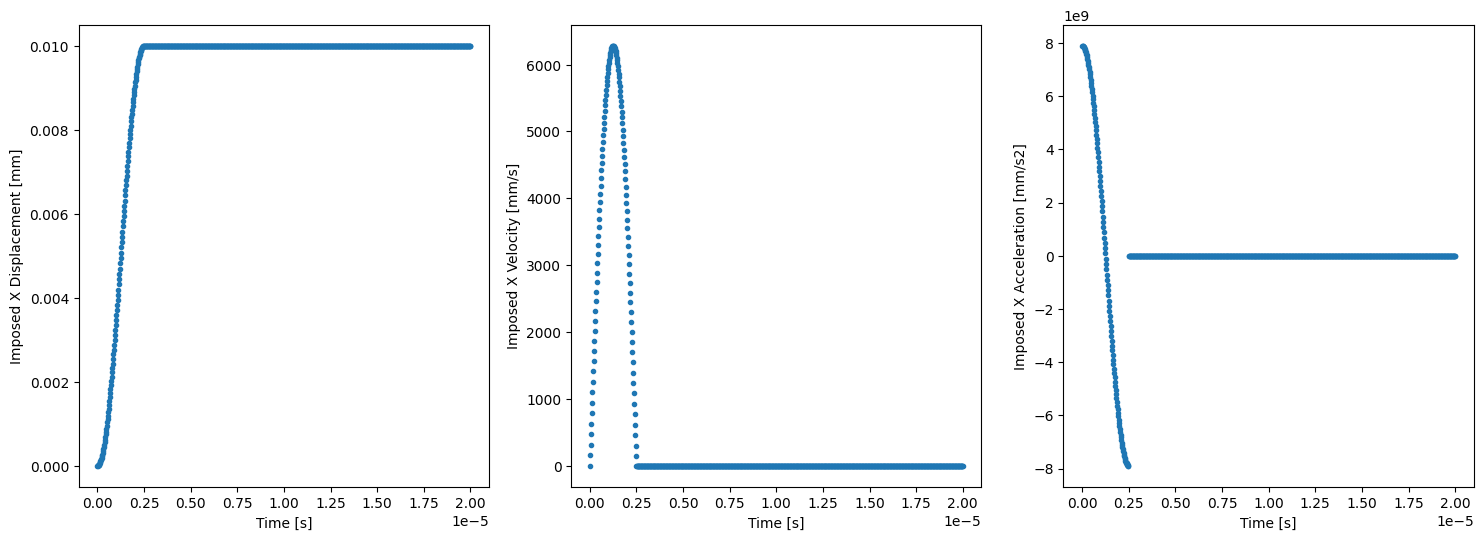

In [4]:
%%px

if comm.rank == 0:
    t_sampling = np.linspace(timestepping_parameters['initial_time'], 
                             timestepping_parameters['total_time'], 
                             1000) 
    U_imp_sampling = np.zeros_like(t_sampling)
    V_imp_sampling = np.zeros_like(t_sampling)
    A_imp_sampling = np.zeros_like(t_sampling)
    
    for i in enumerate (t_sampling):
        U_imp_sampling[i[0]] = U_imp.subs({t_sp:t_sampling[i[0]]})
        V_imp_sampling[i[0]] = V_imp.subs({t_sp:t_sampling[i[0]]})
        A_imp_sampling[i[0]] = A_imp.subs({t_sp:t_sampling[i[0]]})
        
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    ax[0].plot(t_sampling, U_imp_sampling, ls='none', marker='.')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Imposed X Displacement [mm]')
    ax[1].plot(t_sampling, V_imp_sampling, ls='none', marker='.')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Imposed X Velocity [mm/s]')
    ax[2].plot(t_sampling, A_imp_sampling, ls='none', marker='.')
    ax[2].set_xlabel('Time [s]')
    ax[2].set_ylabel('Imposed X Acceleration [mm/s2]');

In [5]:
%%px

mesh = dolfinx.mesh.create_rectangle(MPI.COMM_WORLD, 
                                     [np.array([-geometry_parameters['Lx']/2, -geometry_parameters['Ly']/2]), 
                                      np.array([+geometry_parameters['Lx']/2, +geometry_parameters['Ly']/2])], 
                                     [mesh_parameters['nx'], mesh_parameters['ny']], 
                                     dolfinx.mesh.CellType.triangle)
gdim = mesh.topology.dim
fdim = gdim - 1 
# mesh_plotter(mesh)

As explained in the `Elastodynamics_Explicit-Theory` the CFL condition for an explicit elastodynamics solver is based on the minimum distance between nodes in the mesh. Nonetheless, and to the best of our knowledge, `dolfinx:v0.6.0-r1` does not have a built-in function that calculates the minimum distance between nodes in an element, yet the maximum counterpart can be determined using `dolfinx.cpp.mesh.h`. Hence, given that the elements here implemented are not distorted, and considering the safety factor used for the CFL condition, the minimum in the domain of the maximum distance between two nodes of an element is hereafter used as `h_min` without compromising the stability of the solution.

In [6]:
%%px

h_min_local= min(dolfinx.cpp.mesh.h(mesh, 
                                    gdim, 
                                    range(mesh.topology.index_map(gdim).size_local))) #Minimum internodal distance h of every processor submesh
h_min = np.asarray(comm.gather(h_min_local, root=0)) # Gather the minimum internodal distance of every processor submesh in an array at processor 0
if comm.rank == 0:  #Calculate the global minimum of h at processor 0
    h_min = min(h_min)  
h_min = MPI.COMM_WORLD.bcast(h_min, root=0) #Broadcast to every processor the global minimum of h.

In [7]:
%%px

# Geometrical regions  
def top(x):
    return np.isclose(x[1], +geometry_parameters["Ly"]/2)
def bottom(x):
    return np.isclose(x[1], -geometry_parameters["Ly"]/2)
def right (x):
    return np.isclose(x[0], +geometry_parameters["Lx"]/2)
def left (x):
    return np.isclose(x[0], -geometry_parameters["Lx"]/2)

# Geometrical sets
top_facets    = dolfinx.mesh.locate_entities_boundary(mesh, fdim, top)
bottom_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, bottom)
right_facets  = dolfinx.mesh.locate_entities_boundary(mesh, fdim, right)
left_facets   = dolfinx.mesh.locate_entities_boundary(mesh, fdim, left)

tagged_facets = np.hstack([top_facets, 
                           bottom_facets, 
                           right_facets, 
                           left_facets])

tag_values = np.hstack([np.full_like(top_facets,    1), 
                        np.full_like(bottom_facets, 2),
                        np.full_like(right_facets,  3),
                        np.full_like(left_facets,   4)])

tagged_facets_sorted = np.argsort(tagged_facets)

mt = dolfinx.mesh.meshtags(mesh, fdim, 
                           tagged_facets[tagged_facets_sorted], 
                           tag_values[tagged_facets_sorted])

# Domain and subdomain measures
dx  = ufl.Measure("dx", domain=mesh)                         # Domain measure
ds  = ufl.Measure("ds", domain=mesh, subdomain_data=mt)      # External Boundary measure
dS  = ufl.Measure("dS", domain=mesh, subdomain_data=mt)      # External/Internal measure
n   = ufl.FacetNormal(mesh)                                  # External normal to the boundary

At this point, we have to also include a vector field `ones_a` which stores the unit nodal acceleration vector required for lumping the Consistent Mass matrix. Despite it being constant in value (and equal to `(1,1)`) all along the domain, a `dolfinx.fem.function` (and not a `dolfinx.fem.Constant`) must be used, as explained afterwards.

In [8]:
%%px

# --------- Main functions and function spaces
element_u = ufl.VectorElement('CG', mesh.ufl_cell(), degree=1, dim=gdim)
V_t = dolfinx.fem.FunctionSpace(mesh, element_u)
u = dolfinx.fem.Function(V_t, name="Displacement")
u_new = dolfinx.fem.Function(V_t)
v = dolfinx.fem.Function(V_t, name="Velocity")
v_new = dolfinx.fem.Function(V_t)
a = dolfinx.fem.Function(V_t, name="Acceleration")
a_new = dolfinx.fem.Function(V_t)

# --------- Unit nodal acceleration
ones_a = dolfinx.fem.Function(V_t)

# --------- State of each field 
state     = {"u": u, 
             "v": v, 
             "a": a}
state_new = {"u_new": u_new, 
             "v_new": v_new, 
             "a_new": a_new}

In [9]:
%%px

# Clamped left (ux=uy=0, vx=vy=0, ax=ay=0) 
left_u = dolfinx.fem.Constant(mesh, PETSc.ScalarType((0,0)))
left_v = dolfinx.fem.Constant(mesh, PETSc.ScalarType((0,0)))
left_a = dolfinx.fem.Constant(mesh, PETSc.ScalarType((0,0)))
blocked_dofs_left_Vt = dolfinx.fem.locate_dofs_topological(V_t, fdim, left_facets)
bc_u_left = dolfinx.fem.dirichletbc(left_u, blocked_dofs_left_Vt, V_t)
bc_v_left = dolfinx.fem.dirichletbc(left_v, blocked_dofs_left_Vt, V_t)
bc_a_left = dolfinx.fem.dirichletbc(left_a, blocked_dofs_left_Vt, V_t)

# Imposed displacement right (ux=U_imp(t), vx=U_imp'(t), ax=U_imp''(t))
right_ux = dolfinx.fem.Constant(mesh,PETSc.ScalarType(0))
right_vx = dolfinx.fem.Constant(mesh,PETSc.ScalarType(0))
right_ax = dolfinx.fem.Constant(mesh,PETSc.ScalarType(0))
right_boundary_dofs_Vtx = dolfinx.fem.locate_dofs_topological(V_t.sub(0), fdim, right_facets)
bc_ux_right = dolfinx.fem.dirichletbc(right_ux, right_boundary_dofs_Vtx, V_t.sub(0))
bc_vx_right = dolfinx.fem.dirichletbc(right_vx, right_boundary_dofs_Vtx, V_t.sub(0))
bc_ax_right = dolfinx.fem.dirichletbc(right_ax, right_boundary_dofs_Vtx, V_t.sub(0))

# Collect the BCs
bcs_u = [bc_u_left, bc_ux_right]
bcs_v = [bc_v_left, bc_ux_right]
bcs_a = [bc_a_left, bc_ax_right]

In [10]:
%%px

t       = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))
delta_t = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))

# Material properties
E   = dolfinx.fem.Constant(mesh, PETSc.ScalarType(1))
nu  = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))
rho = dolfinx.fem.Constant(mesh, PETSc.ScalarType(1))
c1  = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))
c2  = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))

# Body forces
b = dolfinx.fem.Constant(mesh, PETSc.ScalarType((0,0)))

## Kinetic energy density
kinetic_energy_density = 0.5 * rho * ufl.inner(v,v)

### Dissipated energy density
eps_v = ufl.variable(ufl.sym(ufl.grad(v)))
dissipated_power_density = 0.5 * (c1 * ufl.inner(v,v) + c2 * ufl.inner(eps_v,eps_v))

# Lame constants (Plane strain)
mu    = E / (2.0 * (1.0 + nu))
lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

## Infinitesimal strain tensor
eps = ufl.variable(ufl.sym(ufl.grad(u)))

## Strain energy density (Linear elastic)
elastic_energy_density = lmbda / 2 * ufl.tr(eps) ** 2 + mu * ufl.inner(eps,eps)

# Stress tensor
sigma = ufl.diff(elastic_energy_density, eps) + c2*eps_v

## External workd density
external_work_density = ufl.dot(b,u)

# System's energy components
kinetic_energy   = kinetic_energy_density * dx
dissipated_power = dissipated_power_density * dx
elastic_energy   = elastic_energy_density * dx 
external_work    = external_work_density * dx 

potential_energy = elastic_energy - external_work
total_energy     = kinetic_energy + potential_energy

# Energy derivatives
u_test = ufl.TestFunction(V_t)
P_du = ufl.derivative(potential_energy, u, u_test) 
K_dv = ufl.derivative(kinetic_energy,   v, u_test)
Q_dv = ufl.derivative(dissipated_power, v, u_test)

# Residual 
Res = ufl.replace(K_dv, {v: a}) + Q_dv + P_du

Once defined the variational formulation of the problem, the obtention of the Consistent `M` and Lumped `M_lumped` mass matrices can be taken forward. In particular, the former can be directly determined by taking the bilinear form within `K_dv`, which can be achieved by using `ufl.lhs`. The `ufl.replace` is used to ensure that the proper Trial and Test functions of `V_t` will be used to compute the bilinear form. 

Then, the form of the lumped mas matrix `M_lumped_form` is defined using the `ufl.action` instruction so that the former is the result of the action of `M` (a bilinear form) over `ones_a` (a linear form). Dur to this `ones_a` cannot be defined as a `dolfinx.fem.Constant`. This implies that `M_lumped_form` is also a linear form. 

In matricial notation, this latter instruction is equivalent to the mathematical expression:

$$
\underline{M_l} = \underline{\underline{M}}\underline{1}
$$

where $\underline{M_l}$ is the diagonal of the Lumped Mass matrix $\underline{\underline{M_l}}$ defined in `03-Elastodynamics_Explicit-Theory`.

At the same time, the linear form of the nodal forces $\underline{F}$ is assigned to `F_form`. 

In [11]:
%%px

M = ufl.lhs(ufl.replace(K_dv,{v: ufl.TrialFunction(V_t)}))
M_lumped_form = dolfinx.fem.form(ufl.action(M, ones_a))
F_form = dolfinx.fem.form(ufl.replace(-(P_du+Q_dv),{u:u_new}))

In [12]:
%%px

# Magnitudes of interest
kinetic_energy_form       = dolfinx.fem.form(kinetic_energy)
dissipated_power_form     = dolfinx.fem.form(dissipated_power)
elastic_energy_form       = dolfinx.fem.form(elastic_energy)
potential_energy_form     = dolfinx.fem.form(potential_energy)
total_energy_form         = dolfinx.fem.form(potential_energy + kinetic_energy)
reaction_force_right_form = dolfinx.fem.form(ufl.inner(n,sigma*n)*ds(3))

In what concerns the iterative resolution of the problem, there exists major differences with the implicit elastodynamics solver, as it was shown in `03-Elastodynamics_Explicit-Theory` notebook. Nonetheless, focusing only on the computational aspect of the differences, the main aspect to point out concerns the computation of the Lumped Mass matrix and the vector of nodal forces. 

Firstly, as previously stated, `M_lumped_form` is a linear form and not a bilinear one, and thus it is associated with a vector, and not a matrix. Nonetheless, for the Lumped Mass matrix is diagonal it can be treated as a vector instead without any loss of information. In such a case, the matrix-vector multiplication and matrix inversion operations are substituted by component-wise vector-vector multiplication and component-wise inversion, respectively. The combination of both aforementioned operations is done using `petsc.pointwiseDivide` function.

Besides, given that the system here considered is assumed to not change its mass ditribution with time, the computation of the Lumped Mass "vector" `M_lumped` can be done just once before the time stepping, for it will remain constant all along the simulation time. On the other hand, the vector of nodal forces `F` must be computed at each time step for it varies from instant to instant. In order to keep the memory requirements low, `F` is destroyed once it is no longer needed at each time step.

In [13]:
%%px

# Initialization
t0         = timestepping_parameters['initial_time']
total_time = timestepping_parameters["total_time"]
explicit_safety_factor = timestepping_parameters["explicit_safety_factor"]

E.value   = material_properties["E"]
nu.value  = material_properties["nu"]
rho.value = material_properties["rho"]
c1.value  = material_properties["c1"]
c2.value  = material_properties["c2"]

b.value = b_

t.value = t0

for const in [left_u,left_v,left_a]:
    const.value = (0.,0.)

for func in [u,v,a] :
    func.x.array[:] = 0.
    
ones_a.x.array[:] = 1.

stp_cont = 0    
ts = []
kinetic_energies       = []
dissipated_energies    = []
dissipated_energy      = 0
elastic_energies       = []
external_works         = []
potential_energies     = []
reaction_force_right_s = []

M_lumped = dolfinx.fem.petsc.assemble_vector(M_lumped_form)
M_lumped.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
M_lumped.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
     
# Critical time increment (approximated CFL condition)
c = np.sqrt((E.value/rho.value)*((1-nu.value)/((1+nu.value)*(1-2*nu.value)))) 
delta_t_critic = h_min/c
delta_t0 = delta_t_critic/explicit_safety_factor
delta_t.value = delta_t0

with dolfinx.io.XDMFFile(comm,'tmp.xdmf','w') as xdmf_file:
    xdmf_file = dolfinx.io.XDMFFile(mesh.comm, OTP_settings['xdmf_filename'], "w")
    xdmf_file.write_mesh(mesh)
    xdmf_file.write_function(u, t.value)

if comm.rank == 0:
    print ('RESOLUTION STATUS')
    sys.stdout.flush()

while float(t.value) < total_time:
    
    #if comm.rank == 0:
    #    print(f"Solving for t = {t.value}")
    #    sys.stdout.flush()
    
    right_ux.value = float(U_imp.subs({t_sp:t.value}))
    right_vx.value = float(V_imp.subs({t_sp:t.value}))
    right_ax.value = float(A_imp.subs({t_sp:t.value}))
    
    #Update displacement field
    u_new.x.array[:] = u.x.array + delta_t*v.x.array + 0.5*delta_t**2*a.x.array
    dolfinx.fem.set_bc(u_new.vector,bcs_u)
    u_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
    # Update acceleration
    F = dolfinx.fem.petsc.assemble_vector(F_form)
    F.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    F.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
    a_new.vector.pointwiseDivide(F, M_lumped)
    a_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    dolfinx.fem.set_bc(a_new.vector,bcs_a)
    a_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    F.destroy()
    
    # Update velocity
    v_new.x.array[:] = v.x.array + 0.5*delta_t*(a_new.x.array + a.x.array)
    dolfinx.fem.set_bc(v_new.vector,bcs_v)
    v_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

     # Copy i+1 into i
    u.x.array[:] = u_new.x.array
    v.x.array[:] = v_new.x.array
    a.x.array[:] = a_new.x.array
    
    dissipated_energy += float(comm.allreduce(float(delta_t)*dolfinx.fem.assemble_scalar(dissipated_power_form), op=MPI.SUM)) 
 
    t.value += float(delta_t)
    delta_t.value = float(ufl.conditional(ufl.lt(delta_t0,total_time-t), 
                                                 delta_t0,
                                                 total_time - t))
    
    kinetic_energies = np.concatenate((kinetic_energies,
                             [comm.allreduce(dolfinx.fem.assemble_scalar(kinetic_energy_form), op=MPI.SUM)]))
    dissipated_energies = np.concatenate((dissipated_energies,[dissipated_energy]))
    elastic_energies = np.concatenate((elastic_energies,
                            [comm.allreduce(dolfinx.fem.assemble_scalar(elastic_energy_form), op=MPI.SUM)]))
    potential_energies = np.concatenate((elastic_energies,
                            [comm.allreduce(dolfinx.fem.assemble_scalar(potential_energy_form), op=MPI.SUM)]))
    reaction_force_right_s = np.concatenate((reaction_force_right_s,
                            [comm.allreduce(dolfinx.fem.assemble_scalar(reaction_force_right_form), op=MPI.SUM)]))
    ts = np.concatenate((ts,[t.value]))
    
    #with dolfinx.io.XDMFFile(comm,OTP_settings['xdmf_filename'],'a') as xdmf_file:
    #    xdmf_file.write_function(u, t.value)
    
    if comm.rank == 0:
        if stp_cont != round((100*t.value/total_time)):
            stp_cont = round((100*t.value/total_time))
            print (f"="*stp_cont+"> "+str(stp_cont)+"%", end="\r") 
            sys.stdout.flush()
            
            #with dolfinx.io.XDMFFile(comm,OTP_settings['xdmf_filename'],'a') as xdmf_file:
            #    xdmf_file.write_function(u, t.value)

[stdout:0] RESOLUTION STATUS


%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[output:0]

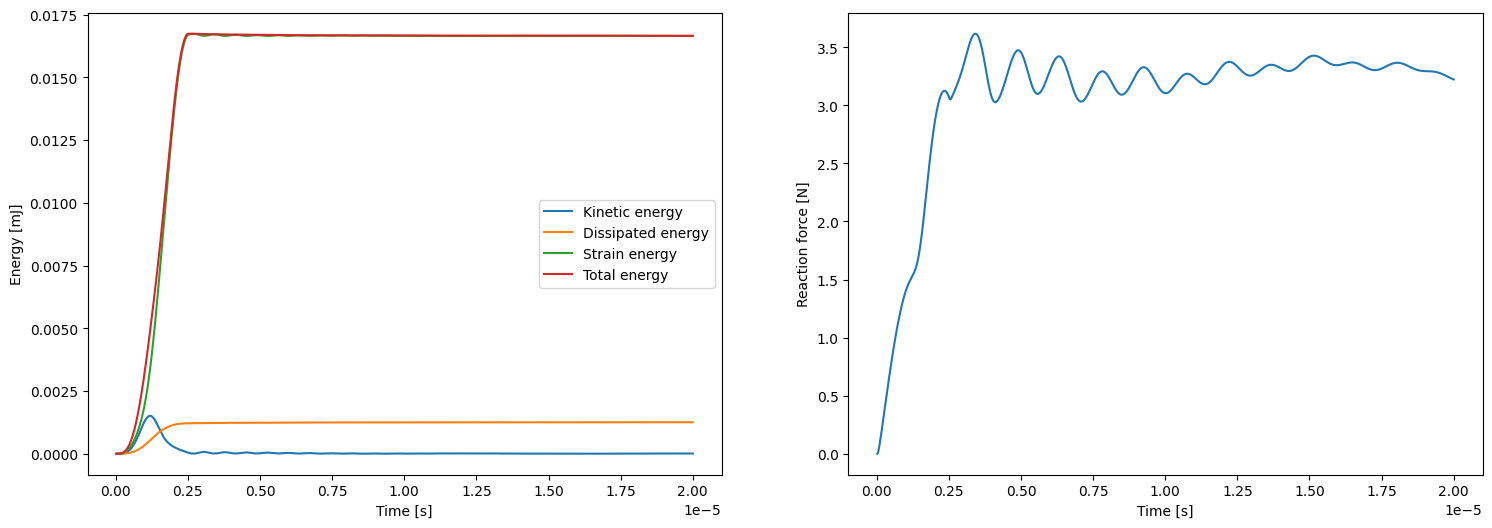

In [14]:
%%px

if comm.rank == 0:
    fig2, ax2 = plt.subplots(1, 2, figsize=(18,6))
    
    ax2[0].plot(ts, kinetic_energies, label='Kinetic energy')
    ax2[0].plot(ts, dissipated_energies, label='Dissipated energy')
    ax2[0].plot(ts, elastic_energies, label='Strain energy')
    ax2[0].plot(ts, kinetic_energies + elastic_energies, label='Total energy')
    ax2[0].set_xlabel('Time [s]')
    ax2[0].set_ylabel('Energy [mJ]')
    ax2[0].legend()
    
    ax2[1].plot (ts, reaction_force_right_s)
    ax2[1].set_xlabel('Time [s]')
    ax2[1].set_ylabel('Reaction force [N]')
    plt.show()